# Project 5 - Semi-Supervised Image Classification using a CNN

## Abstract

This project focuses on semi-supervised image classification using the CIFAR-10 dataset. With only a subset of the images having known labels, the objective is to leverage unlabeled examples to improve classification accuracy. The approach involves using clustering and iterative training to infer labels on unlabeled data, then investigating whether this improves the accuracy of a CNN model trained from scratch.

To achieve this, the project first experiments with dimensionality reduction using PCA and K-means clustering to estimate class labels on unlabeled data. The project compares clustering with PCA to clustering using embeddings from pretrained models, and uses the most effective approach in the CNN.

In the second stage, the project investigates whether inferred labels can improve the classification accuracy of a CNN model trained from scratch. The project uses three experimental models to compare the effects of adding inferred labels to the training dataset. Model A trains the CNN only on data with known class labels, while Model B trains the CNN on data with known class labels and labels inferred using KMeans clustering on embeddings. Finally, Model C trains the CNN on data with known class labels and labels inferred using Model A.

### Team Members and Contributions

- Manveer Singh Tamber (mtamber@uwaterloo.ca)
    - Devised experiments for investigating the importance of using inferred labels for training CNNs to make classifications. 
    - Wrote model training and evaluation code within the three experimental settings
    - Generated and compared model results across different M values
- Jagvir Dehal (jdehal@uwaterloo.ca)
    - Worked on normalizing and reducing the images using PCA, and clustering these using K-means.
    - Alongside clustering, created a function that generates a mapping to the real labels using ground truth labels we have
    - Investigated the use of different pre-trained models for embeddings vs. the PCA reduction
    
Overall, the contributions through discussion and cross-checking code was 50/50.

### Code Libraries

#### Pytorch [(site)](https://pytorch.org/get-started/locally/)

PyTorch (`torch`/`torchvision`) was used to define, train, and evaluate the CNN models
`torchsummary` was used to output the details of the CNN model

Install command: ```pip3 install torch torchvision torchsummary```

#### Keras [(site)](https://keras.io/getting_started/)

Keras was used for the CIFAR-10 dataset, along with running the pretrained models (VGG16, VGG19, EfficientNetV2B2)

Install command: `pip3 install tensorflow`

#### sklearn [(site)](https://scikit-learn.org/stable/index.html)

sklearn was used for the PCA and KMeans functions

Install command: `pip install -U scikit-learn`

## Initialization

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import copy

# Loading CIFAR-10
from keras.datasets import cifar10 as dataset

# PCA function
from sklearn.decomposition import PCA

# Clustering functions
from sklearn.cluster import KMeans

2023-04-26 18:14:36.511507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:14:37.292127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.7/lib64
2023-04-26 18:14:37.292209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.7/lib64
2023-04-26 18:14:37.29

### Load data from keras.datasets

Data is loaded into variables train_X, train_y (for training data and labels) and test_X, test_y (for test data and labels)

In [2]:
(train_X, train_y), (test_X, test_y) = dataset.load_data()

train_y = train_y[:,0]
test_y = test_y[:,0]

print("Data shape:")
display(np.shape(train_X), np.shape(test_X))
print("\nLabels shape:")
display(np.shape(train_y), np.shape(test_y))

Data shape:


(50000, 32, 32, 3)

(10000, 32, 32, 3)


Labels shape:


(50000,)

(10000,)

### Display data

Quick display of a random sample of data with their associated labels. CIFAR-10 is a data set of 32x32 RGB images of airplanes, automobiles, etc. as shown below.

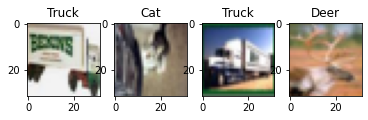

In [3]:
# Translation dictionary to go from the label values to their corresponding English text
idx_to_class = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

classes = idx_to_class.values()
num_labels = len(classes)

for index, img in enumerate(np.random.choice(len(train_X), 4, replace=False)):
    plt.subplot(141 + index)
    plt.imshow(train_X[img])
    plt.title(idx_to_class[train_y[img]])
plt.show()

### Select M labels

Here we select M images out of the training data, and call them `known_X`. These data points have the associated ground truth labels of `known_y`. The rest of the data is assumed to have no ground truth labels and are called `unknown_X`. However, to measure the accuracy of our learning models, we keep the unknown labels as `unknown_y`.

In [4]:
M = 5000

known_X = train_X[:M]
unknown_X = train_X[M:]

known_y = known_labels = train_y[:M]
unknown_y = unknown_labels = train_y[M:]

## PCA Reduction

We run a linear dimentionality reduction (PCA) on the training and test data to visualize, cluster, and overall reduce the dimensionality of the images. The reduction returns the components in order of decreasing explained variance (the amount of variance explained by each component), so our visualizations use the first two components.

### Normalize the data

Before we can run our PCA reduction, we need to normalize the data to float values between 0 and 1. This is for both the PCA reduction we are running now, and for the deep learning models we will run later on. We will also keep a copy of the data pre-normalization to be used in the pretrained models (as they have their own preprocessing functions).

In [5]:
# Raw values are used for the pretrained models
train_X_raw = copy.deepcopy(train_X)

# Assuming max value is 255
train_X = train_X / np.max(train_X)
test_X = test_X / np.max(test_X)
known_X = known_X / np.max(known_X)
unknown_X = unknown_X / np.max(unknown_X)

This is the actual `pca_reduction` function. We use enough components to capture 80% of the variance in the data.

In [6]:
def pca_reduction(variance, train_X=train_X, test_X=test_X, train_y=train_y, test_y=test_y):
    # Flatten images
    train_X_flat = train_X.reshape(-1, np.prod(train_X.shape[1:]))
    test_X_flat = test_X.reshape(-1, np.prod(test_X.shape[1:]))
    
    # Fit the PCA
    pca = PCA(n_components=variance, whiten=True)
    pca.fit(train_X_flat)
    print("Num components:", pca.n_components_)
    
    # Transform the data
    train_img_pca = pca.transform(train_X_flat)
    test_img_pca = pca.transform(test_X_flat)
    
    return (train_img_pca, test_img_pca)

(train_img_pca, test_img_pca) = pca_reduction(variance=0.8)

Num components: 33


We split the pca result into its own known and unknown arrays and graph the two principal components.

In [7]:
known_img_pca = train_img_pca[:M]
unknown_img_pca = train_img_pca[M:]

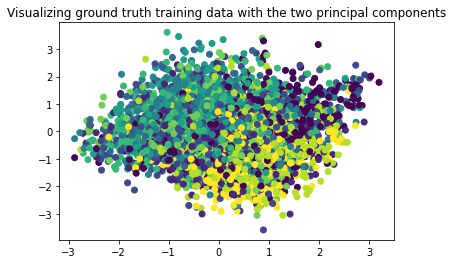

In [8]:
plt.title("Visualizing ground truth training data with the two principal components")
plt.scatter(known_img_pca[:,0], known_img_pca[:,1], c=known_labels)
plt.show()

## K-means clustering

Here we define two functions, `run_clustering` (the K-means clustering function) and `generate_guesses` (a function that takes the clusters from K-means and guesses their associated ground-truth labels).

`run_clustering` simply clusters the fit_data using K-means, and predicts the closest cluster that each sample in predict_data (our unknown/unlabelled data) belongs to. It then gets a mapping from the K-means clusters to predicted labels using `generate_guesses`, and measures the accuracy of these predicted labels using the ground truth labels. Finally, it returns the predicted labels (for use in graphing).

`generate_guesses` is used to produce a best guess for a cluster-label map. There are two approaches that we implemented.

The **first approach** involves mapping each cluster to the label that appears most within that cluster. This gives us a mapping that doesn't usually use all of the labels, but will give us the highest accuracy overall. This is because some labels get more evenly distributed between the clusters, meaning their count wont be as high in any cluster, and thus won't be assigned. However, although some labels won't have an associated cluster, each cluster that gets mapped will correctly asseses the highest number of labels it can, thus leading to a higher accuracy overall.
    
The **second approach** involves creating a cluster-label array in which the rows are the cluster # and the cols are the label #. The values of the array are the # of occurences of the label in the cluster. We take the highest cluster-label pair in the array and assign the cluster its corresponding label. Then, we remove both the cluster and label from the array (effectively reducing the size to 9x9), and take the next highest cluster-label pair. We repeat this until the array is empty, giving us a one-to-one mapping of clusters to labels. However, this removes many cluster-label pairings each iteration, which leads to many higher value mappings to not be considered. Thus, the overall accuracy will be lower than our maximal approach (approach 1)
    
With this information, **we decided to go with approach \#1** for maximal accuracy., but have left approach \#2's code in the function so that it can easily be used by returning `alt_guess` from the function instead of `guess`.

In [9]:
def generate_guesses(kmeans, known_labels, num_labels):
    guess = {}
    cluster_bins = np.zeros((kmeans.n_clusters, num_labels), dtype="int")
    
    for cluster in range(kmeans.n_clusters):
        # get all points in cluster
        index = np.where(kmeans.labels_ == cluster)
        labels = known_labels[index]
        
        # find the most likely label for the cluster and set the guess
        cluster_bins[cluster] = np.bincount(labels, minlength=10)
        guess[cluster] = np.argmax(cluster_bins[cluster])
    
    # Experimental alternative method to guessing the cluster->label mapping
    # This method gives a one-to-one mapping between them
    #print(cluster_bins)
    alt_guess = {}
    for i in range(num_labels):
        opt_idx = np.unravel_index(cluster_bins.argmax(), cluster_bins.shape)
        cluster_bins[opt_idx[0],:] = -1
        cluster_bins[:, opt_idx[1]] = -1
        alt_guess[opt_idx[0]] = opt_idx[1]
    
    return guess

In [10]:
def run_clustering(fit_data, predict_data, labels=known_y, unknown_labels=unknown_y, runs=10,
                   n_clusters=10, sample_size=M, num_labels=num_labels, seed=0):
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init=runs)
    kmeans.fit(fit_data)
    
    cluster_to_label = generate_guesses(kmeans, labels, num_labels)
    guess_labels = np.vectorize(lambda x: cluster_to_label[x])
    
    prediction = kmeans.predict(predict_data)
    predicted_labels = guess_labels(prediction)
    print("Labels used:")
    display(np.unique(predicted_labels))
    print()
    
    print("Accuracy of clustering:")
    display(np.sum(unknown_labels == predicted_labels) / len(unknown_labels))
    
    return predicted_labels

### Running K-means on the PCA reduction

Now we run the K-means clustering on our PCA reduction. Built into the function is an accuracy measurement, so we can see the accuracy of using the raw PCA features in K-means is about 22.4%. This does fluctuate between runs on the same data, but we can reproduce the results by using a set seed for the K-means clustering (default 0).

In [11]:
pca_labels = run_clustering(known_img_pca, unknown_img_pca)

Labels used:


array([0, 1, 3, 4, 5, 7, 8, 9])


Accuracy of clustering:


0.22384444444444446

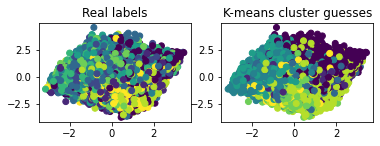

In [12]:
plt.subplot(221)
plt.title("Real labels")
plt.scatter(unknown_img_pca[:,0], unknown_img_pca[:,1], c=unknown_labels)
plt.subplot(222)
plt.title("K-means cluster guesses")
plt.scatter(unknown_img_pca[:,0], unknown_img_pca[:,1], c=pca_labels)
plt.show()

## Pre-trained models

The `get_embeddings` function takes a Pretrained Model, a preprocessing function, and raw image data to compute the embeddings of all the images under the pretrained model. Below we use the VGG16, VGG19, and EfficientNetV2B2 models and compare their overall speed and clustering accuracy, both between one another and PCA clustering.

In [13]:
def get_embeddings(PreTrainedModel, preprocess, data=train_X_raw):
    pt_model = PreTrainedModel(
        include_top=False,
        weights="imagenet",
        input_shape=train_X.shape[1:],
        pooling="avg"
    )
    
    pt_train_X = copy.deepcopy(data)
    if preprocess is not None:
        pt_train_X = preprocess(pt_train_X)
    
    #print("Before/After preprocess:")
    #display(data[0,0,0])
    #display(pt_train_X[0,0,0])
    #print()
    
    pt_embeddings = pt_model.predict(pt_train_X)
    return pt_embeddings

### VGG 16

We import and compute the vgg16 embeddings. Overall the accuracy of clustering using these is about 29.2%.

In [14]:
from keras.applications import VGG16, vgg16

In [15]:
# Get feature embeddings
vgg16_embeddings = get_embeddings(VGG16, vgg16.preprocess_input)

2023-04-26 18:15:23.280987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.7/lib64
2023-04-26 18:15:23.281035: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1563/1563 [==============================] - 92s 59ms/step


In [16]:
# Run clustering
vgg16_known = vgg16_embeddings[:M]
vgg16_unknown = vgg16_embeddings[M:]
vgg16_labels = run_clustering(vgg16_known, vgg16_unknown)

Labels used:


array([0, 1, 3, 4, 5, 6, 8, 9])


Accuracy of clustering:


0.29217777777777776

### VGG19

We import and compute the vgg19 embeddings. Overall the accuracy of clustering using these is about 30.6%.

In [17]:
from keras.applications import VGG19, vgg19

In [18]:
vgg19_embeddings = get_embeddings(VGG19, vgg19.preprocess_input)

1563/1563 [==============================] - 84s 53ms/step


In [19]:
vgg19_known = vgg19_embeddings[:M]
vgg19_unknown = vgg19_embeddings[M:]
vgg19_labels = run_clustering(vgg19_known, vgg19_unknown)

Labels used:


array([0, 1, 4, 5, 6, 8, 9])


Accuracy of clustering:


0.30644444444444446

### EfficientNet (B2)

We import and compute the ENET embeddings. Overall the accuracy of clustering using these is about 29.4%.

In [20]:
from keras.applications import EfficientNetV2B2 as ENET

In [21]:
enet_embeddings = get_embeddings(ENET, None)

1563/1563 [==============================] - 36s 22ms/step


In [22]:
enet_known = enet_embeddings[:M]
enet_unknown = enet_embeddings[M:]
enet_labels = run_clustering(enet_known, enet_unknown)

Labels used:


array([0, 1, 3, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.2935111111111111

Clearly, any of the pretrained models we used here are significantly better than using the PCA data, with each of the embeddings being about 10% more accurate. Thus, we decided to proceed with one of the pretrained models for the deep learning section. The question is which one?

The accuracies between VGG16, VGG19, and ENET are all within 1% of each other, so changing the seed can change which of these give the highest accuracy at any given time. Thus, it is hard to say objectively which is the best model for our use case. However, because of both its reliability between runs and its speed in generating the embeddings, we decided to proceed with using EfficientNetV2B2.

## Deep Learning

##### Import Necessary Libraries for PyTorch

In [23]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torch import optim

##### Transformations for Training Image Augmentation
The transformations used are a random horizontal flip with probability 0.5, a color jitter that randomly changes the brightness and contrast by a factor of 0.1 each, and a random affine transformation that randomly rotates the images up to 2 degrees in either direction and randomly translates the image by 1% in either direction. The transformations were found to be helpful in improving the accuracies of the trained models on the test set.

In [24]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                      transforms.RandomAffine(degrees=2, translate=(0.01, 0.01), interpolation=InterpolationMode.BILINEAR),
                                    ])

##### Perform Training on GPU if available

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### Define CNN Model for Classification
The CNN used has 4 convolutional layers and uses relu activation after each convolutional layer. Max pooling is performed after every 2 convolutional layers. After the convolutional layers the tensors are flattened, put through dropout regularization with probability 0.5, and are then put through 2 linear layers to get the final model output. 

In [26]:
from torchsummary import summary
class ClassificationNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = torch.nn.Linear(400, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        embedding = F.relu(self.fc1(x))
        output = self.fc2(embedding)
        return output

model = ClassificationNet(10).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
            Conv2d-2           [-1, 32, 28, 28]           4,640
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           9,248
            Conv2d-5           [-1, 16, 10, 10]           4,624
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Dropout-7                  [-1, 400]               0
            Linear-8                   [-1, 32]          12,832
            Linear-9                   [-1, 10]             330
Total params: 32,122
Trainable params: 32,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 0.12
Estimated Total Size (MB): 0.54
---------------------------------------------

##### Define PyTorch Dataset for Loading Data into Model
Transformations are applied within the \__getitem__ function. The Dataset consists of an image, the associated label, and a weight measuring importance for the sample.

In [27]:
class MNISTDataset(Dataset):
    def __init__(self, X, y, weights, transform=None):
        self.data = torch.tensor(X).type(torch.FloatTensor)
        self.labels = torch.tensor(y).type(torch.LongTensor)
        self.weights = torch.tensor(weights).type(torch.FloatTensor)
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_arr = self.data[idx]
        img_arr = torch.moveaxis(img_arr, -1, -3)
        label = self.labels[idx]
        weight = self.weights[idx]
        if self.transform:
            img_arr = self.transform(img_arr)
        
        return img_arr, label, weight

##### Define Functions for Model Training and Testing
The train function trains the model and reports loss every 10 epochs and the test function is used to calculate accuracy on the test set of the model.

In [28]:
def train(model, train_dataloader, test_dataloader, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        loss_sum = 0
        model.train()
        for i, (img_arrs, labels, weights) in enumerate(train_dataloader):
            optimizer.zero_grad() 
            output = model(img_arrs.to(device))               
            loss = loss_func(output, labels.to(device))
            loss = loss * weights.to(device)
            loss = torch.mean(loss)
            loss.backward()         
            optimizer.step()
            loss_sum += loss.detach().item()
        if (epoch + 1) % 10 == 0:    
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss_sum / len(train_dataloader)))
        #test(model, test_dataloader)
    
def test(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for img_arrs, labels, weights in test_dataloader:
            output = model(img_arrs.to(device))
            pred_y = torch.max(output, 1)[1].data.squeeze().cpu()
            correct += (pred_y == labels).sum().item() 
            total += labels.size(0)
    print('Test Accuracy of the model on the test images: ', correct/total)
    return correct/total

The following is the training of the models in the three settings. This is shown to explain the underlying process. Model A trains the CNN only on data with known class labels,  Model B trains the CNN on data with known class labels and unlabelled data having labels inferred using KMeans clustering on embeddings. Finally, Model C trains the CNN on data with known class labels and unlabelled data having labels inferred using Model A. Note this is with M=5000. For models B and C, since the unlabelled data with inferred labels is less reliable than the data with ground truth labels available, these unlabelled samples are weighed less in the CrossEntropy loss function by a factor of 0.1.

##### Model A: Train Model on only Data where Ground Truth Labels are Available.
With M=5000, this model attains an accuracy of 50.66% on the test set.

In [29]:
loss_func = torch.nn.CrossEntropyLoss(reduction='none')   
train_dataloader = torch.utils.data.DataLoader(MNISTDataset(known_X, known_y, np.ones(known_y.shape), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(MNISTDataset(test_X, test_y, np.ones(test_y.shape)), batch_size=128, shuffle=False)
model_a = ClassificationNet(10).to(device)
optimizer = optim.Adam(model_a.parameters(), lr = 0.001)            
train(model_a, train_dataloader, test_dataloader, optimizer, num_epochs=50)
test(model_a, test_dataloader)

Epoch [10/50], Loss: 1.7592
Epoch [20/50], Loss: 1.5979
Epoch [30/50], Loss: 1.4763
Epoch [40/50], Loss: 1.4301
Epoch [50/50], Loss: 1.4072
Test Accuracy of the model on the test images:  0.5066


0.5066

##### Model B: Train Model on Data where Ground Truth Labels are Available + Unlabelled Data where Label is Inferred from K-Means Clustering on EfficientNet Embeddings
With M=5000, this model attains an accuracy of 55.23% on the test set. Notably, this is higher than the accuracy in Model A.

In [30]:
train_dataloader = torch.utils.data.DataLoader(MNISTDataset(np.append(known_X, unknown_X, axis=0), np.append(known_y, enet_labels, axis=0), np.append(np.ones(known_y.shape), 0.1*np.ones(enet_labels.shape), axis=0), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
model_b = ClassificationNet(10).to(device)
optimizer = optim.Adam(model_b.parameters(), lr = 0.001)   
train(model_b, train_dataloader, test_dataloader, optimizer, num_epochs=50)
test(model_b, test_dataloader)

Epoch [10/50], Loss: 0.3165
Epoch [20/50], Loss: 0.2925
Epoch [30/50], Loss: 0.2814
Epoch [40/50], Loss: 0.2737
Epoch [50/50], Loss: 0.2685
Test Accuracy of the model on the test images:  0.5523


0.5523

##### Model C: Train Model on Data where Ground Truth Labels are Available + Unlabelled Data where Label is Inferred from First Trained Model Classifications
First we observe that the accuracy of the inferred labels is 50.72%. Then, with M=5000, this model attains an accuracy of 53.51% on the test set. Notably, this is higher than the accuracy in Model A.

In [31]:
model_a.eval()

unknown_dataloader = torch.utils.data.DataLoader(MNISTDataset(unknown_X, unknown_y, np.ones(unknown_y.shape)), batch_size=64, shuffle=False)
model_a_unknown_predictions = []
for images, labels, weights in unknown_dataloader:
    output = model_a(images.to(device))
    output = output.detach().cpu()
    model_a_unknown_predictions.append(output)
    
model_a_unknown_predictions = np.concatenate(model_a_unknown_predictions)
model_a_unknown_predictions = np.argmax(model_a_unknown_predictions, 1)
np.sum(model_a_unknown_predictions == unknown_y)/len(unknown_y)

0.5071555555555556

In [32]:
train_dataloader = torch.utils.data.DataLoader(MNISTDataset(np.append(known_X, unknown_X, axis=0), np.append(known_y, model_a_unknown_predictions, axis=0), np.append(np.ones(known_y.shape), 0.1*np.ones(model_a_unknown_predictions.shape), axis=0), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
model_c = ClassificationNet(10).to(device)
optimizer = optim.Adam(model_c.parameters(), lr = 0.001)   
train(model_c, train_dataloader, test_dataloader, optimizer, num_epochs=50)
test(model_c, test_dataloader)

Epoch [10/50], Loss: 0.2292
Epoch [20/50], Loss: 0.2143
Epoch [30/50], Loss: 0.2044
Epoch [40/50], Loss: 0.2006
Epoch [50/50], Loss: 0.1927
Test Accuracy of the model on the test images:  0.5351


0.5351

##### Comparison of the three different models described above for different values of M. The code here is re-used from above.

In [33]:
# M values to test
M_vals = [500, 1000, 2000, 5000, 10000, 20000, 40000]
model_a_accuracies = []
model_b_accuracies = []
model_c_accuracies = []

for M in M_vals:
    print("M:", M)
    known_X = train_X[:M]
    unknown_X = train_X[M:]
    known_y = known_labels = train_y[:M]
    unknown_y = unknown_labels = train_y[M:]
    
    # Raw values are used for the pretrained models
    train_X_raw = copy.deepcopy(train_X)

    known_X = known_X / np.max(known_X)
    unknown_X = unknown_X / np.max(unknown_X)

    (train_img_pca, test_img_pca) = pca_reduction(variance=0.8)
    known_img_pca = train_img_pca[:M]
    unknown_img_pca = train_img_pca[M:]

    enet_known = enet_embeddings[:M]
    enet_unknown = enet_embeddings[M:]
    enet_labels = run_clustering(enet_known, enet_unknown, known_y, unknown_y, runs="auto", n_clusters=10, sample_size=M, num_labels=num_labels, seed=0)

    loss_func = torch.nn.CrossEntropyLoss(reduction='none')   
    
    train_dataloader = torch.utils.data.DataLoader(MNISTDataset(known_X, known_y, np.ones(known_y.shape), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
    test_dataloader = torch.utils.data.DataLoader(MNISTDataset(test_X, test_y, np.ones(test_y.shape)), batch_size=128, shuffle=False)
    model_a = ClassificationNet(10).to(device)
    optimizer = optim.Adam(model_a.parameters(), lr = 0.001)            
    train(model_a, train_dataloader, test_dataloader, optimizer, num_epochs=50)
    model_a_accuracies.append(test(model_a, test_dataloader))
    
    train_dataloader = torch.utils.data.DataLoader(MNISTDataset(np.append(known_X, unknown_X, axis=0), np.append(known_y, enet_labels, axis=0), np.append(np.ones(known_y.shape), 0.1*np.ones(enet_labels.shape), axis=0), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
    model_b = ClassificationNet(10).to(device)
    optimizer = optim.Adam(model_b.parameters(), lr = 0.001)   
    train(model_b, train_dataloader, test_dataloader, optimizer, num_epochs=50)
    model_b_accuracies.append(test(model_b, test_dataloader))
    
    model_a.eval()
    unknown_dataloader = torch.utils.data.DataLoader(MNISTDataset(unknown_X, unknown_y, np.ones(unknown_y.shape)), batch_size=64, shuffle=False)
    model_a_unknown_predictions = []
    for images, labels, weights in unknown_dataloader:
        output = model_a(images.to(device))
        output = output.detach().cpu()
        model_a_unknown_predictions.append(output)
    model_a_unknown_predictions = np.concatenate(model_a_unknown_predictions)
    model_a_unknown_predictions = np.argmax(model_a_unknown_predictions, 1)
    
    train_dataloader = torch.utils.data.DataLoader(MNISTDataset(np.append(known_X, unknown_X, axis=0), np.append(known_y, model_a_unknown_predictions, axis=0), np.append(np.ones(known_y.shape), 0.1*np.ones(model_a_unknown_predictions.shape), axis=0), transform=train_transform), batch_size=128, shuffle=True, num_workers=8)
    model_c = ClassificationNet(10).to(device)
    optimizer = optim.Adam(model_c.parameters(), lr = 0.001)   
    train(model_c, train_dataloader, test_dataloader, optimizer, num_epochs=50)
    model_c_accuracies.append(test(model_c, test_dataloader))

M: 500
Num components: 33
Labels used:


array([1, 2, 3, 4, 6, 7, 9])


Accuracy of clustering:


0.21294949494949494

Epoch [10/50], Loss: 2.0683
Epoch [20/50], Loss: 1.9452
Epoch [30/50], Loss: 1.8236
Epoch [40/50], Loss: 1.7441
Epoch [50/50], Loss: 1.6360
Test Accuracy of the model on the test images:  0.3512
Epoch [10/50], Loss: 0.1653
Epoch [20/50], Loss: 0.1566
Epoch [30/50], Loss: 0.1523
Epoch [40/50], Loss: 0.1494
Epoch [50/50], Loss: 0.1466
Test Accuracy of the model on the test images:  0.2625
Epoch [10/50], Loss: 0.0820
Epoch [20/50], Loss: 0.0781
Epoch [30/50], Loss: 0.0761
Epoch [40/50], Loss: 0.0741
Epoch [50/50], Loss: 0.0734
Test Accuracy of the model on the test images:  0.352
M: 1000
Num components: 33
Labels used:


array([0, 1, 3, 4, 5, 6, 7, 9])


Accuracy of clustering:


0.26710204081632655

Epoch [10/50], Loss: 2.0286
Epoch [20/50], Loss: 1.8694
Epoch [30/50], Loss: 1.7514
Epoch [40/50], Loss: 1.6401
Epoch [50/50], Loss: 1.5774
Test Accuracy of the model on the test images:  0.384
Epoch [10/50], Loss: 0.1920
Epoch [20/50], Loss: 0.1814
Epoch [30/50], Loss: 0.1769
Epoch [40/50], Loss: 0.1734
Epoch [50/50], Loss: 0.1709
Test Accuracy of the model on the test images:  0.3598
Epoch [10/50], Loss: 0.1084
Epoch [20/50], Loss: 0.1020
Epoch [30/50], Loss: 0.1011
Epoch [40/50], Loss: 0.0983
Epoch [50/50], Loss: 0.0957
Test Accuracy of the model on the test images:  0.4019
M: 2000
Num components: 33
Labels used:


array([2, 3, 4, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.2795625

Epoch [10/50], Loss: 1.9150
Epoch [20/50], Loss: 1.7249
Epoch [30/50], Loss: 1.6619
Epoch [40/50], Loss: 1.5756
Epoch [50/50], Loss: 1.4921
Test Accuracy of the model on the test images:  0.4328
Epoch [10/50], Loss: 0.2273
Epoch [20/50], Loss: 0.2124
Epoch [30/50], Loss: 0.2080
Epoch [40/50], Loss: 0.2037
Epoch [50/50], Loss: 0.2002
Test Accuracy of the model on the test images:  0.3831
Epoch [10/50], Loss: 0.1461
Epoch [20/50], Loss: 0.1378
Epoch [30/50], Loss: 0.1336
Epoch [40/50], Loss: 0.1284
Epoch [50/50], Loss: 0.1272
Test Accuracy of the model on the test images:  0.4656
M: 5000
Num components: 33
Labels used:


array([0, 1, 2, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.29617777777777776

Epoch [10/50], Loss: 1.7582
Epoch [20/50], Loss: 1.5401
Epoch [30/50], Loss: 1.4717
Epoch [40/50], Loss: 1.4005
Epoch [50/50], Loss: 1.3982
Test Accuracy of the model on the test images:  0.5058
Epoch [10/50], Loss: 0.3187
Epoch [20/50], Loss: 0.3012
Epoch [30/50], Loss: 0.2902
Epoch [40/50], Loss: 0.2827
Epoch [50/50], Loss: 0.2760
Test Accuracy of the model on the test images:  0.5341
Epoch [10/50], Loss: 0.2370
Epoch [20/50], Loss: 0.2223
Epoch [30/50], Loss: 0.2145
Epoch [40/50], Loss: 0.2085
Epoch [50/50], Loss: 0.2042
Test Accuracy of the model on the test images:  0.5434
M: 10000
Num components: 33
Labels used:


array([0, 1, 2, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.295125

Epoch [10/50], Loss: 1.5723
Epoch [20/50], Loss: 1.4050
Epoch [30/50], Loss: 1.3268
Epoch [40/50], Loss: 1.2647
Epoch [50/50], Loss: 1.2144
Test Accuracy of the model on the test images:  0.5723
Epoch [10/50], Loss: 0.4396
Epoch [20/50], Loss: 0.3999
Epoch [30/50], Loss: 0.3819
Epoch [40/50], Loss: 0.3719
Epoch [50/50], Loss: 0.3647
Test Accuracy of the model on the test images:  0.6306
Epoch [10/50], Loss: 0.3400
Epoch [20/50], Loss: 0.3054
Epoch [30/50], Loss: 0.2895
Epoch [40/50], Loss: 0.2805
Epoch [50/50], Loss: 0.2679
Test Accuracy of the model on the test images:  0.6212
M: 20000
Num components: 33
Labels used:


array([0, 1, 3, 4, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.2955333333333333

Epoch [10/50], Loss: 1.4311
Epoch [20/50], Loss: 1.2444
Epoch [30/50], Loss: 1.1427
Epoch [40/50], Loss: 1.0747
Epoch [50/50], Loss: 1.0348
Test Accuracy of the model on the test images:  0.6509
Epoch [10/50], Loss: 0.6477
Epoch [20/50], Loss: 0.5832
Epoch [30/50], Loss: 0.5526
Epoch [40/50], Loss: 0.5384
Epoch [50/50], Loss: 0.5153
Test Accuracy of the model on the test images:  0.6865
Epoch [10/50], Loss: 0.5828
Epoch [20/50], Loss: 0.5109
Epoch [30/50], Loss: 0.4734
Epoch [40/50], Loss: 0.4557
Epoch [50/50], Loss: 0.4341
Test Accuracy of the model on the test images:  0.6665
M: 40000
Num components: 33
Labels used:


array([0, 1, 2, 5, 6, 7, 8, 9])


Accuracy of clustering:


0.2947

Epoch [10/50], Loss: 1.3342
Epoch [20/50], Loss: 1.1653
Epoch [30/50], Loss: 1.0623
Epoch [40/50], Loss: 0.9906
Epoch [50/50], Loss: 0.9364
Test Accuracy of the model on the test images:  0.6807
Epoch [10/50], Loss: 1.1095
Epoch [20/50], Loss: 0.9559
Epoch [30/50], Loss: 0.8861
Epoch [40/50], Loss: 0.8389
Epoch [50/50], Loss: 0.8122
Test Accuracy of the model on the test images:  0.6981
Epoch [10/50], Loss: 1.0108
Epoch [20/50], Loss: 0.8747
Epoch [30/50], Loss: 0.8101
Epoch [40/50], Loss: 0.7757
Epoch [50/50], Loss: 0.7474
Test Accuracy of the model on the test images:  0.7067


The following plot compares Models A, B, and C across different values of M. We observe that both models that make use of inferred labels (Model B and Model C) outperformed Model A, which only made use of the ground truth labels for training. This was true generally across different values of M (the number of datapoints with ground truth labels) ranging from 500 to 40000. However, Model B was more sensitive when the M value was low and performed poorly, but was otherwise taking turns trading the lead with Model C. Overall, Model C is much more robust across all values of M. 

Model B's poor performance with low values of M may be because the accuracy of the inferred labels from the clustering is low when M values are small. Model C's performance being superior to model A makes sense because Model C leverages Model A's predictions to make use of the unlabelled data. Model B and C trading leads is interesting because the accuracy of Model C's inferred labels are always greater than the accuracy of Model B's inferred labels. Perhaps there is a regularizing effect from Model B's less accurate inferred labels that explains Model B's occasional superior performance.

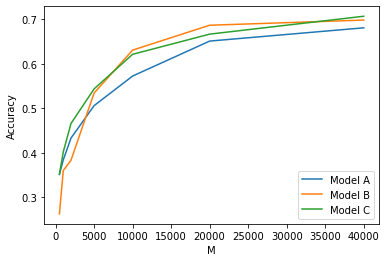

In [34]:
plt.plot(M_vals, model_a_accuracies, label='Model A')
plt.plot(M_vals, model_b_accuracies, label='Model B')
plt.plot(M_vals, model_c_accuracies, label='Model C')
plt.xlabel("M")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Conclusions

In conclusion, this project aimed to improve semi-supervised image classification using the CIFAR-10 dataset by leveraging unlabeled data. The project used clustering and iterative training to infer labels on unlabeled data and investigate whether this approach could improve the accuracy of a CNN model trained from scratch. The results of the experiments showed that adding inferred labels to unlabelled data in the training dataset improves the accuracy of the CNN model.

Both models that make use of inferred labels (Model B and Model C) outperformed Model A, which only made use of the ground truth labels for training. This was true generally across different values of M (the number of datapoints with ground truth labels) ranging from 500 to 40000. However, Model B was more sensitive when the M value was low and performed poorly, but was otherwise taking turns trading the lead with Model C. Overall, Model C is much more robust across all values of M.

These findings highlight the effectiveness of using inferred labels to leverage unlabeled data and improve the performance of a CNN model trained from scratch. Furthermore, the project's comparison of clustering using PCA to clustering using embeddings from pretrained models provides valuable insights into the most effective approach. In particular, embeddings are expected to capture more of the semantic information in the images compared to raw image features, thus leading to better clustering. Overall, this project provides a framework for improving image classification accuracy using semi-supervised learning and demonstrates the potential of leveraging unlabeled data to enhance the performance of deep learning models.